<a href="https://colab.research.google.com/github/soniajoseph/Collaborative-Representation-Based-Classification/blob/master/Pruning_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from time import time
import copy
import pandas as pd 

## The Unexpected Effects of Pruning Neural Nets

*This project was done as a challenge for [for.ai](for.ai), a multi-disciplinary distributed artificial intelligence research collaboration.*

Pruning is deleting connections in a neural net in order to improve generalization and reduce computational resources. Two kinds of pruning exist: weight-pruning, in which the largest weights by absolute value are set to zero; and unit-pruning, in which the smallest neurons are set to zero by a vector-wise metric like L2-norm.

Here, I examine the relationship between pruning and accuracy on a vanilla neural net. Before running any experiments, I hypothesize that accuracy for the pruned neural net will slightly rise (due to the regularization), and then have a negative linear correlation with the amount pruned. I also hypothesize that unit-pruning, in deleting entire neurons instead of individual weights, will have a more dramatic negative effect than weight-pruning. 

## First, let's load, normalize, and visualize the MNIST dataset.



In [0]:
def load_MNIST():
  """Function to load and normalize MNIST data""" 
  train = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ]))
  test = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ]))
  print("MNIST datset loaded and normalized.")
  train_loader = torch.utils.data.DataLoader(dataset=train, shuffle=True, batch_size=100)
  test_loader = torch.utils.data.DataLoader(dataset=test, shuffle=False, batch_size=100)
  print("PyTorch DataLoaders loaded.")
  return train, test, train_loader, test_loader


In [0]:
def visualize_MNIST(train_loader):
  """Function to visualize data given a DataLoader object"""
  dataiter = iter(train_loader)
  images, labels = dataiter.next()
  print("image shape:", images.shape, "\n label shape:", labels.shape)
  # visualize data
  fig, ax = plt.subplots(2,5)
  for i, ax in enumerate(ax.flatten()):
      im_idx = np.argwhere(labels == i)[0][0]
      plottable_image = images[im_idx].squeeze()
      ax.imshow(plottable_image)

MNIST datset loaded and normalized.
PyTorch DataLoaders loaded.
image shape: torch.Size([100, 1, 28, 28]) 
 label shape: torch.Size([100])


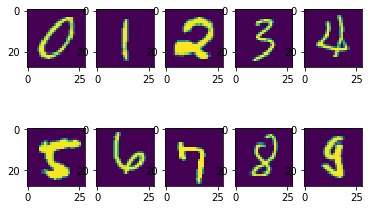

In [4]:
# load and visualize MNISt
train, test, train_loader, test_loader = load_MNIST()
visualize_MNIST(train_loader)

## Now let's build a vanilla neural net with four hidden layers without pruning.

We'll keep things simple and leave out biases, convolutions, and pooling.

In [0]:
class Net(nn.Module):
  """A non-sparse neural network with four hidden fully-connected layers"""

  def __init__(self):
    super(Net,self).__init__()
    self.input_layer = nn.Linear(784, 1000, bias=False)
    self.hidden1_layer = nn.Linear(1000, 1000, bias=False)
    self.hidden2_layer = nn.Linear(1000, 500, bias=False)
    self.hidden3_layer = nn.Linear(500, 200, bias=False)
    self.hidden4_layer = nn.Linear(200, 10, bias=False)

  def forward(self, x):
    x = self.input_layer(x)
    x = F.relu(x)
    x = self.hidden1_layer(x)
    x = F.relu(x)
    x = self.hidden2_layer(x)
    x = F.relu(x)
    x = self.hidden3_layer(x)
    x = F.relu(x)
    x = self.hidden4_layer(x)
    output = F.log_softmax(x, dim=1)

    return output

## Let's train our vanilla neural net.

In [0]:
def train(model, train_loader, epochs=3, learning_rate=0.001):
  """Function to train a neural net"""

  lossFunction = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  time0 = time()
  total_samples = 0 

  for e in range(epochs):
    print("Starting epoch", e)
    total_loss = 0

    for idx, (images,labels) in enumerate(train_loader):
      images = images.view(images.shape[0],-1) # flatten
      optimizer.zero_grad() # forward pass
      output = model(images)
      loss = lossFunction(output,labels) # calculate loss
      loss.backward() # backpropagate
      optimizer.step() # update weights

      total_samples += labels.size(0)
      total_loss += loss.item()

      if idx % 100 == 0:
        print("Running loss:", total_loss)

  final_time = (time()-time0)/60 
  print("Model trained in ", final_time, "minutes on ", total_samples, "samples")


In [0]:
model = Net()
train(model, train_loader)

Starting epoch 0
Running loss: 2.3025763034820557
Running loss: 79.13857460021973
Running loss: 113.31019903719425
Running loss: 138.79075822234154
Running loss: 160.88071709871292
Running loss: 181.42165705934167
Starting epoch 1
Running loss: 0.22079169750213623
Running loss: 15.352100413292646
Running loss: 30.58726792782545


## Now we'll test our vanilla neural net.

In [0]:
def test(model, test_loader):
  """Test neural net"""

  correct = 0
  total = 0 

  with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
      images = images.view(images.shape[0],-1) # flatten
      output = model(images)
      values, indices = torch.max(output.data, 1)
      total += labels.size(0)
      correct += (labels == indices).sum().item()

    acc = correct / total * 100
    # print("Accuracy: ", acc, "% for ", total, "training samples")

  return acc


In [0]:
acc = test(model, test_loader)
print("The accuracy of our vanilla NN is", acc, "%")

## A ~96% accuracy for our vanilla NN seems reasonable. Now let's do some weight and unit pruning.

In [0]:

def sparsify_by_weights(model, k):
  """Function that takes un-sparsified neural net and does weight-pruning
  by k sparsity"""

  # make copy of original neural net
  sparse_m = copy.deepcopy(model)

  with torch.no_grad():
    for idx, i in enumerate(sparse_m.parameters()): 
      if idx == 4: # skip last layer of 5-layer neural net
        break 
      # change tensor to numpy format, then set appropriate number of smallest weights to zero
      layer_copy = torch.flatten(i)
      layer_copy = layer_copy.detach().numpy()
      indices = abs(layer_copy).argsort() # get indices of smallest weights by absolute value
      indices = indices[:int(len(indices)*k)] # get k fraction of smallest indices 
      layer_copy[indices] = 0 

      # change weights of model
      i = torch.from_numpy(layer_copy)
  
  return sparse_m  

In [0]:
def l2(array):
  return np.sqrt(np.sum([i**2 for i in array]))

def sparsify_by_unit(model, k):
  """Creates a k-sparsity model with unit-level pruning that sets columns with smallest L2 to zero."""
  
  # make copy of original neural net
  sparse_m = copy.deepcopy(model)

  for idx, i in enumerate(sparse_m.parameters()):
    if idx == 4: # skip last layer of 5-layer neural net
      break
    layer_copy = i.detach().numpy()
    indices = np.argsort([l2(i) for i in layer_copy])
    indices = indices[:int(len(indices)*k)]
    layer_copy[indices] = 0
    i = torch.from_numpy(layer_copy)
  
  return sparse_m 


In [0]:
def get_pruning_accuracies(model, prune_type):
  """ Takes a model and prune type ("weight" or "unit") and returns a DataFrame of pruning accuracies for given sparsities."""

  df = pd.DataFrame({"sparsity": [], "accuracy": []})
  sparsities = [0.0, 0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.97, 0.99]

  for s in sparsities:
    if prune_type == "weight":
      new_model = sparsify_by_weights(model, s)
    elif prune_type == "unit":
      new_model = sparsify_by_unit(model, s)
    else:
      print("Must specify prune-type.")
      return 
    acc = test(new_model, test_loader)
    df = df.append({"sparsity": s, "accuracy": acc}, ignore_index=True)

  return df 

## Results

In [0]:
df_weight = get_pruning_accuracies(model, "weight")
df_unit = get_pruning_accuracies(model, "unit")

print("Accuracies for Weight Pruning")
print(df_weight)

print()

print("Accuracies for Unit Pruning")
print(df_unit)

In [0]:
plt.figure()
plt.title("Accuracy vs Sparsity")
plt.plot(df_unit["sparsity"], df_unit["accuracy"], label="Unit-pruning")
plt.plot(df_weight["sparsity"], df_weight["accuracy"], label="Weight-pruning")
plt.xlabel("Sparsity (as fraction)")
plt.ylabel("% Accuracy")
plt.legend()

## Using New-Found Sparsity to Speed up the Neural Net

We

## Discussion (pre-literature review)

Clearly, my hypothesis that accuracy will rise and then negatively correlate in a roughly linear way with pruning was incorrect. The figure instead shows a dramatic nonlinear relationship between accuracy and pruning. Accuracy remains roughly constant until dropping off at about 75% sparsity for weight-pruning and until 70% sparsity for unit-pruning. My hypothesis that unit-pruning impacts accuracy more dramatically than weight-pruning held up.

These results are fascinating: Less than 25% of the neural net represents important information about its function. The data also suggest that accuracy may slightly increase with a light amount of pruning (~30%), although I would run on more iterations with a larger dataset to be sure. It would make sense that keeping the net's smaller weights reduces its generalization.


## Literature Review

Let's turn to existing papers to get a better grasp on the pruning phenomenon. 

In ["The Lottery Ticket Hypothesis"](https://arxiv.org/pdf/1803.03635.pdf), the authors put forth the idea:

> "A randomly-initialized, dense neural network contains a subnetwork that is initialized such that—when trained in isolation—it can match the test accuracy of the
original network after training for at most the same number of iterations."
>

Pruning the network automatically finds the "winning ticket" subnetwork, whose accuracy is comparable to that of the fully trained net. The idea is similar to the one proposed in ["Optimal Brain Damage"](http://yann.lecun.com/exdb/publis/pdf/lecun-90b.pdf), in which the authors prune a network based on second-derivative information.

## Further Directions

Questions remain. The theory behind the pruning-accuracy relationship remains unclear, and it is an ongoing area of research. Are there other ways of finding these "winning ticket" subnetworks besides pruning (e.g. directly from the objective function)? Why does one have to train a largely overparameterized network first for the winning ticket to arise? Can we find winning ticket subnetwork before training the full network (i.e. during training)? 

I am also curious if CNNs, RNNs, and ResNets show the same relationship between pruning and accuracy as the vanilla NN examined here. I am interested in the effect of pruning the weights by magnitude of the entire net (opposed to layer by layer), and using magnitude measures other than absolute value and L2-norm. And what about deleting the largest weights and neurons, opposed to the smallest?

Lastly, I am interested in using pruning in artificial nets as a computational model for [synaptic pruning](https://en.wikipedia.org/wiki/Synaptic_pruning) with microglia in biological brains. It is possible that synaptic pruning conserves biological resources, improves brain functioning, or both. 